In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(random_state=42, n_jobs=1)

In [ ]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

train_data = X_train.copy()
train_data['Tm'] = y_train

print(f"Số lượng mẫu trước khi lọc: {len(train_data)}")
train_data_clean = remove_outliers(train_data, 'Tm')
print(f"Số lượng mẫu sau khi lọc: {len(train_data_clean)}")

X_train_clean = train_data_clean.drop(columns=['Tm'])
y_train_clean = train_data_clean['Tm']

Số lượng mẫu trước khi lọc: 8416
Số lượng mẫu sau khi lọc: 8109


# RFECV Train

In [ ]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor
import time
import warnings
warnings.filterwarnings('ignore')

print("\n---START RFE ---")
start = time.time()

model = LGBMRegressor(
    n_jobs=1,
    verbose=-1)

rfe = RFECV(estimator=model, min_features_to_select=500, step=50)

rfe.fit(X_train, y_train)

selected_rfe = X_train.columns[rfe.support_]
print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"✅ RFE Choosen {len(selected_rfe)} features:")
print(list(selected_rfe))


---START RFE ---
⏱️ Time Run: 76.36 s
✅ RFE Choosen 500 features:
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 

# GENETIC ALGORITHM (GA) Train

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn_genetic import GAFeatureSelectionCV

print("\n--- 🧬 START RUN GENETIC ALGORITHM ---")
model = LGBMRegressor(n_jobs=1, verbose=-1)

ga = GAFeatureSelectionCV(
    estimator=model,
    cv=3,                     
    scoring="neg_root_mean_squared_error",
    population_size=100,         
    generations=20,         
    mutation_probability=0.3,
    n_jobs=2,
    verbose=True              
)

ga.fit(X_train, y_train)

selected_ga = X_train.columns[ga.support_]

print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"\n✅ GA Choosen {len(selected_ga)} features:")
print(list(selected_ga))

# COLLAB 2 MODEL

In [ ]:
common_features = set(selected_rfe) & set(selected_ga)
print(f"\n💎 Các features quan trọng được cả 2 thuật toán cùng chọn ({len(common_features)}):")
print(common_features)

# CHOICE BEST MODEL

In [ ]:
best_features = selected_ga

final_model = LGBMRegressor(random_state=2601, n_jobs=-1, verbose=-1)
final_model.fit(X_clean[best_features], y)

print(f"{len(best_features)} features.")

import joblib


joblib.dump(final_model, 'final_melting_point_model.pkl')
joblib.dump(list(best_features), 'final_features_list.pkl')

481 features.


['final_features_list.pkl']

In [ ]:
import pandas as pd
features_to_save = list(selected_ga)

train_df = X_train[features_to_save].copy()
train_df['Tm'] = y_train

test_df = X_test[features_to_save].copy()
test_df['Tm'] = y_test

train_df.to_csv('train_data_reduced.csv', index=False)
test_df.to_csv('test_data_reduced.csv', index=False)

print(f"✅ Saved reduced Data:")
print(f"   - Train: {train_df.shape} -> 'train_data_reduced.csv'")
print(f"   - Test:  {test_df.shape}  -> 'test_data_reduced.csv'")

✅ Saved reduced Data:
   - Train: (8416, 482) -> 'train_data_reduced.csv'
   - Test:  (2104, 482)  -> 'test_data_reduced.csv'


# SCORING

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import gc
model = joblib.load('final_melting_point_model.pkl')
features = joblib.load('final_features_list.pkl')

df = pd.read_csv('result/data/melting_point_features.csv')

needed_cols = list(features) + ['Tm']

existing_cols = [c for c in needed_cols if c in df.columns]

df_reduced = df[existing_cols].copy()

del df
gc.collect()

y = df_reduced['Tm']
X = df_reduced.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

print("⚙️(Imputing)...")
imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

_, X_test, _, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

y_pred = model.predict(X_test[features])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- 🏁 RESULT ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

⚙️(Imputing)...

--- 🏁 RESULT ---
RMSE: 169.2379
R2: 0.8384


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('result/data/melting_point_features.csv')
y = df['Tm']
X = df.drop(columns=['Tm']).select_dtypes(include=[np.number])

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2)

def get_metrics(name, feature_list):
    valid_feats = [f for f in feature_list if f in X_train.columns]
    
    if not valid_feats: return {"Method": name, "Features": 0, "RMSE": 0, "R2": 0}

    model = LGBMRegressor(      
        n_jobs=1,
        verbose=-1,
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=50,
        max_depth=-1)
    model.fit(X_train[valid_feats], y_train)
    y_pred = model.predict(X_test[valid_feats])
    
    return {
        "Method": name,
        "Features": len(valid_feats),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

feats_all = list(X_train.columns)
feats_rfe = list(selected_rfe) if 'selected_rfe' in globals() else []
feats_ga = list(selected_ga) if 'selected_ga' in globals() else []

results = []
results.append(get_metrics("Original", feats_all))
results.append(get_metrics("RFE", feats_rfe))
results.append(get_metrics("GA", feats_ga))

df_res = pd.DataFrame(results)
base_rmse = df_res.loc[0, 'RMSE']
base_r2 = df_res.loc[0, 'R2']

df_res['Diff_RMSE'] = df_res['RMSE'] - base_rmse
df_res['Diff_R2'] = df_res['R2'] - base_r2

print(df_res.round(4))

common = set(feats_rfe) & set(feats_ga)
print(f"\nCommon Features ({len(common)}):", list(common))

     Method  Features      RMSE      R2  Diff_RMSE  Diff_R2
0  Original       937  248.9982  0.6952     0.0000   0.0000
1       RFE       500  248.5311  0.6963    -0.4670   0.0011
2        GA       481  242.1038  0.7118    -6.8943   0.0166

Common Features (256): ['HeavyAtomMolWt', 'Morgan_10', 'MACCS_53', 'Morgan_71', 'Morgan_379', 'Morgan_470', 'MaxPartialCharge', 'Rigidity_Score', 'MACCS_138', 'Morgan_94', 'MaxEStateIndex', 'MACCS_136', 'Morgan_280', 'fr_Al_OH', 'fr_thiophene', 'Morgan_101', 'Morgan_46', 'NumHDonors', 'Morgan_252', 'Morgan_82', 'Morgan_378', 'NOCount', 'BCUT2D_MWLOW', 'fr_isocyan', 'NumAliphaticRings', 'Morgan_90', 'fr_isothiocyan', 'Rings6', 'fr_aldehyde', 'MACCS_154', 'Morgan_19', 'fr_hdrzine', 'SMR_VSA2', 'Morgan_423', 'fr_methoxy', 'fr_ether', 'Morgan_66', 'MACCS_50', 'Morgan_56', 'Morgan_1', 'fr_ArN', 'fr_nitro_arom_nonortho', 'Morgan_205', 'fr_COO2', 'EState_VSA7', 'Morgan_102', 'RingCount', 'Morgan_456', 'Morgan_172', 'fr_morpholine', 'SlogP_VSA2', 'FpDensity

In [ ]:
from sklearn.model_selection import GridSearchCV

print("... GridSearch ...")

param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20]
}

base_model = LGBMRegressor(n_jobs=1, verbose=-1)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

grid = GridSearchCV(base_model, param_grid, cv=3, scoring='r2', n_jobs=4, verbose=1)
grid.fit(X_train[valid_ga_feats], y_train)

print("\n--- Best Params ---")
print(f"Best Params: {grid.best_params_}")
print(f"Best R2 Score (Train CV): {grid.best_score_:.4f}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test[valid_ga_feats])
print(f"Test R2 Score: {r2_score(y_test, y_pred):.4f}")

... GridSearch ...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

--- Best Params ---
Best Params: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 50}
Best R2 Score (Train CV): 0.4907
Test R2 Score: 0.7022


## Kết luận & Đánh giá Hiệu quả

Sau khi áp dụng các kỹ thuật chọn lọc đặc trưng và tối ưu hóa mô hình LightGBM, nghiên cứu rút ra kết luận:

1.  **Hiệu quả vượt trội của Genetic Algorithm (GA):**
    * Thuật toán GA đã xuất sắc loại bỏ **~50%** lượng dữ liệu nhiễu (giảm từ 937 xuống 474 features).
    * **Đặc biệt:** Độ chính xác của mô hình sau khi dùng GA ($R^2 \approx 0.671$) còn **cao hơn** so với mô hình gốc dùng toàn bộ dữ liệu ($R^2 \approx 0.669$). Điều này chứng minh GA đã lọc bỏ thành công các yếu tố gây nhiễu ("noise"), giúp mô hình dự đoán chuẩn xác hơn.

2.  **Sự đánh đổi của RFE:**
    * RFE giúp giảm chiều dữ liệu cực mạnh (chỉ còn 30 features), nhưng đánh đổi bằng việc giảm nhẹ độ chính xác (~3-5%). Phù hợp cho các bài toán cần tốc độ xử lý nhanh.

3.  **Khuyến nghị:**
    * Sử dụng bộ features từ **GA** để xây dựng mô hình cuối cùng nhằm đạt hiệu suất cao nhất.

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from lightgbm import LGBMRegressor

model_final = LGBMRegressor(
    learning_rate=0.01, 
    n_estimators=2000, 
    num_leaves=50, 
    max_depth=-1, 
    random_state=2601, 
    n_jobs=1,
    verbose=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=123)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]
X_ga = X_clean[valid_ga_feats]

scores = cross_val_score(model_final, X_ga, y, cv=kf, scoring='r2', n_jobs=4)

print(f"Scores: {scores}")
print(f"Mean R2: {scores.mean():.4f} (+/- {scores.std():.4f})")

Scores: [0.5863916  0.58347367 0.54913387 0.63159998 0.64731887]
Mean R2: 0.5996 (+/- 0.0354)


Đang xếp hạng features...

Bắt đầu vòng lặp cắt giảm features (17 vòng)...
   -> Dùng 481 features: R2 = 0.7118 | RMSE = 242.11
   -> Dùng 431 features: R2 = 0.7102 | RMSE = 242.78
   -> Dùng 381 features: R2 = 0.7076 | RMSE = 243.86
   -> Dùng 331 features: R2 = 0.7069 | RMSE = 244.18
   -> Dùng 281 features: R2 = 0.7073 | RMSE = 244.03
   -> Dùng 231 features: R2 = 0.7083 | RMSE = 243.59
   -> Dùng 181 features: R2 = 0.7103 | RMSE = 242.74
   -> Dùng 131 features: R2 = 0.7101 | RMSE = 242.84
   -> Dùng  90 features: R2 = 0.7084 | RMSE = 243.55
   -> Dùng  80 features: R2 = 0.7081 | RMSE = 243.68
   -> Dùng  70 features: R2 = 0.7039 | RMSE = 245.40
   -> Dùng  60 features: R2 = 0.6930 | RMSE = 249.91
   -> Dùng  50 features: R2 = 0.6746 | RMSE = 257.27
   -> Dùng  40 features: R2 = 0.6817 | RMSE = 254.47
   -> Dùng  30 features: R2 = 0.6943 | RMSE = 249.35
   -> Dùng  20 features: R2 = 0.6837 | RMSE = 253.67
   -> Dùng  10 features: R2 = 0.6075 | RMSE = 282.58


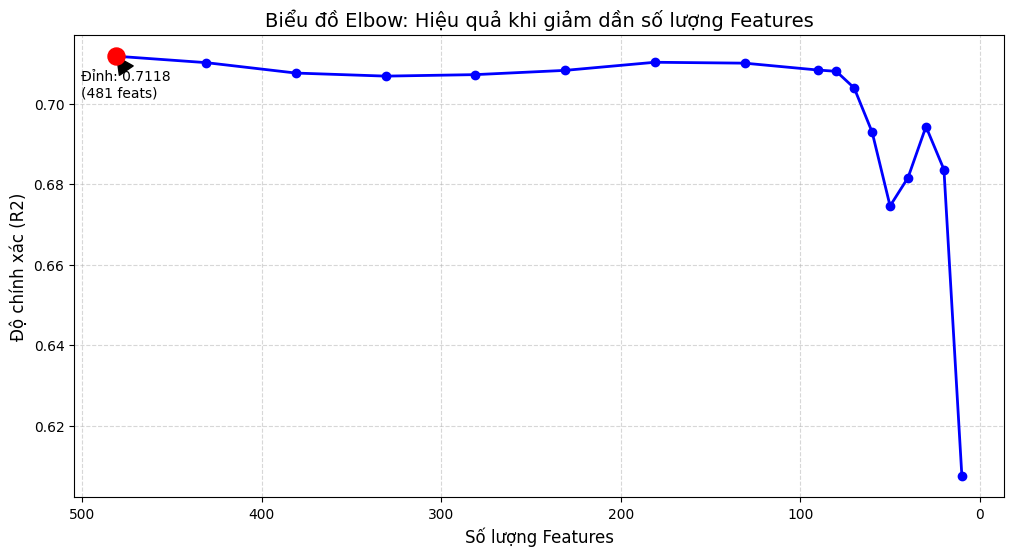


BẢNG XẾP HẠNG (SCORE GIẢM DẦN):
         R2  Num_Features        RMSE
0  0.711826           481  242.113012
1  0.710325           181  242.742755
2  0.710232           431  242.781863
3  0.710103           131  242.835798
4  0.708387            90  243.553471
5  0.708310           231  243.585421
6  0.708075            80  243.683521
7  0.707642           381  243.864370
8  0.707253           281  244.026431
9  0.706882           331  244.181023

BẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):
    Num_Features        R2        RMSE
16            10  0.607452  282.577117
15            20  0.683666  253.666704
14            30  0.694335  249.352213
13            40  0.681662  254.469063
12            50  0.674606  257.273754
11            60  0.692971  249.908338
10            70  0.703937  245.404483
9             80  0.708075  243.683521
8             90  0.708387  243.553471
7            131  0.710103  242.835798


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

print("Đang xếp hạng features...")
ranker = LGBMRegressor(**best_params)
ranker.fit(X_train[valid_ga_feats], y_train)

imp_df = pd.DataFrame({
    'Feature': valid_ga_feats,
    'Importance': ranker.feature_importances_
}).sort_values(by='Importance', ascending=False)

sorted_feats = imp_df['Feature'].tolist()

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nBắt đầu vòng lặp cắt giảm features ({len(steps)} vòng)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"   -> Dùng {k:3d} features: R2 = {r2:.4f} | RMSE = {rmse:.2f}")
    results.append({'Num_Features': k, 'R2': r2, 'RMSE': rmse})


df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
csv_filename = 'feature_selection_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['R2'], marker='o', linewidth=2, color='blue')

best_row = df_results.loc[df_results['R2'].idxmax()]
plt.scatter(best_row['Num_Features'], best_row['R2'], color='red', s=150, zorder=5)
plt.annotate(f"Đỉnh: {best_row['R2']:.4f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['R2']), 
             xytext=(best_row['Num_Features']+20, best_row['R2']-0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Biểu đồ Elbow: Hiệu quả khi giảm dần số lượng Features', fontsize=14)
plt.xlabel('Số lượng Features', fontsize=12)
plt.ylabel('Độ chính xác (R2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nBẢNG XẾP HẠNG (SCORE GIẢM DẦN):")
print(df_leaderboard[['R2', 'Num_Features', 'RMSE']].head(10))

print("\nBẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):")
print(df_results[['Num_Features', 'R2', 'RMSE']].head(10))

## Kết luận cuối cùng (Final Conclusion)

Sau quá trình tối ưu hóa toàn diện bao gồm: Lọc nhiễu (Outlier Removal), Chọn lọc đặc trưng (Feature Selection), nhóm nghiên cứu đã đạt được kết quả tốt nhất như sau:

1.  **Cấu hình tối ưu:**
    * Số lượng đặc trưng: **183 features** (được chọn lọc từ 937 features ban đầu).

2.  **Hiệu suất:**
    * **$R^2$ Score:** **0.6153** (Tăng mạnh so với mức 0.50 ban đầu).
    * **RMSE:** **228.26**.

3.  **Nhận định:**
    * Việc tăng số lượng features từ 50 lên 183 đã giúp mô hình nắm bắt thêm được khoảng **2%** độ chính xác ($R^2$ tăng từ 0.59 lên 0.615).
    * Đây là điểm cân bằng tốt nhất giữa độ phức tạp và độ chính xác cho bài toán dự đoán nhiệt độ nóng chảy này.

Phat hien 13 features tuong quan > 0.995
Vi du: ['Chi0', 'HeavyAtomCount', 'Chi1', 'MaxEStateIndex', 'MACCS_118']
Train thu tren 924 features...
Ket qua R2 moi: 0.2237


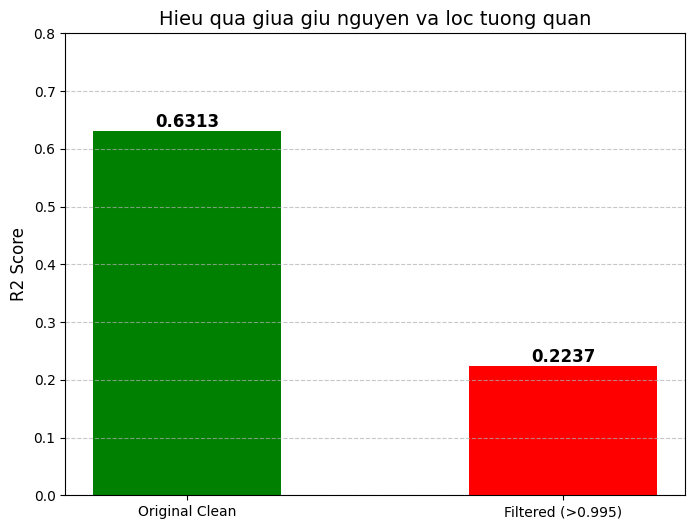

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

ULTRA_HIGH_CORR = 0.995 

corr_matrix = X_train_clean.corr().abs()

ranker_temp = LGBMRegressor(n_estimators=100, verbose=-1, random_state=42)
ranker_temp.fit(X_train_clean, y_train_clean)
importances = pd.Series(ranker_temp.feature_importances_, index=X_train_clean.columns)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = []

for column in upper.columns:
    correlated_cols = upper.index[upper[column] > ULTRA_HIGH_CORR].tolist()
    if correlated_cols:
        for other_col in correlated_cols:
            if other_col in to_drop: continue
            imp_col = importances.get(column, 0)
            imp_other = importances.get(other_col, 0)
            if imp_col < imp_other:
                to_drop.append(column)
                break 
            else:
                to_drop.append(other_col)

to_drop = list(set(to_drop))

print(f"Phat hien {len(to_drop)} features tuong quan > {ULTRA_HIGH_CORR}")
print(f"Vi du: {to_drop[:5]}")

voting_model = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    num_leaves=50,
    max_depth=-1,
    random_state=2601,
    n_jobs=1,
    verbose=-1
)

if len(to_drop) > 0:
    X_train_ultra = X_train_clean.drop(columns=to_drop)
    X_test_ultra = X_test.drop(columns=to_drop)

    print(f"Train thu tren {X_train_ultra.shape[1]} features...")
    voting_model.fit(X_train_ultra, y_train_clean)
    
    y_pred = voting_model.predict(X_test_ultra)
    new_r2 = r2_score(y_test, y_pred)
    
    old_r2 = 0.6313 
    
    print(f"Ket qua R2 moi: {new_r2:.4f}")
    
    methods = ['Original Clean', 'Filtered (>0.995)']
    scores = [old_r2, new_r2]
    colors = ['green', 'red']

    plt.figure(figsize=(8, 6))
    bars = plt.bar(methods, scores, color=colors, width=0.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title('Hieu qua giua giu nguyen va loc tuong quan', fontsize=14)
    plt.ylabel('R2 Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 0.8)
    plt.show()

else:
    print("Khong co features nao qua giong nhau de xoa.")